In [1]:
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


                               DateTime  Voltage Line 1 [V]  \
DateTime                                                      
2020-08-02 00:00:00 2020-08-02 00:00:00              232.39   
2020-08-02 01:00:00 2020-08-02 01:00:00              234.30   
2020-08-02 02:00:00 2020-08-02 02:00:00              234.14   
2020-08-02 03:00:00 2020-08-02 03:00:00              234.99   
2020-08-02 04:00:00 2020-08-02 04:00:00              233.60   
...                                 ...                 ...   
2020-11-30 19:00:00 2020-11-30 19:00:00              233.59   
2020-11-30 20:00:00 2020-11-30 20:00:00              233.99   
2020-11-30 21:00:00 2020-11-30 21:00:00              233.38   
2020-11-30 22:00:00 2020-11-30 22:00:00              233.50   
2020-11-30 23:00:00 2020-11-30 23:00:00              232.89   

                     Voltage Line 2 [V]  Voltage Line 3 [V]  \
DateTime                                                      
2020-08-02 00:00:00              232.27              2

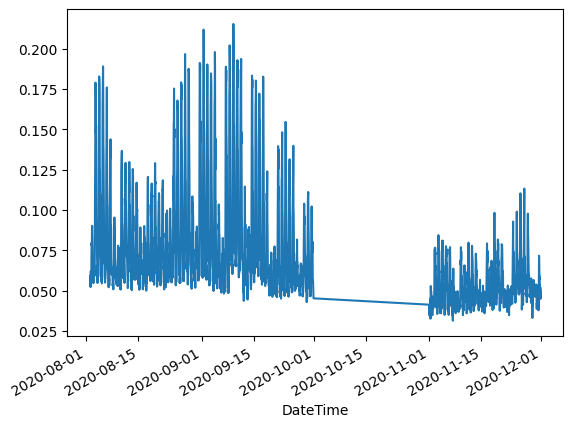

In [20]:
df = pd.read_csv('No_october.csv')
df.DateTime = pd.to_datetime(df.DateTime,dayfirst=True)
df.index = pd.to_datetime(df['DateTime'], format='%d/%m/%Y %H:%M:%S')
df["Active Total Energy in MWh"]= df['Active Total Energy (Wh) [Wh]'].astype(float)/ 1000000
df["Combined Active Power in MW"] = df['Combined Active Power Line 1+2 +3 (watt)'].astype(float) / 1000000
print(df)
df['Combined Active Power in MW'].plot()
# plt.show()
target= df['Combined Active Power in MW']

In [21]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_percentage_error as mape

def plot_predictions1(model, X, y):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'])
  plt.plot(df['Actuals'])
  plt.legend(['Actuals','Test Predictions'])
  return df, mse(y, predictions), r2(y,predictions), mape (y,predictions)


In [22]:
target.head()

DateTime
2020-08-02 00:00:00    0.056684
2020-08-02 01:00:00    0.059487
2020-08-02 02:00:00    0.052799
2020-08-02 03:00:00    0.055698
2020-08-02 04:00:00    0.052330
Name: Combined Active Power in MW, dtype: float64

In [23]:
temp_df = pd.DataFrame({'Power':target,"Avg Temp":df["Temp"],"High Temp":df['Hi'],"Low Temp":df["Low"],"Combined Current":df['Total Current in Line 1+2+3']})
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df

,Power,Avg Temp,High Temp,Low Temp,Combined Current,Seconds
DateTime,,,,,,
2020-08-02 00:00:00,0.056684,28.7,29.6,27.6,250.42,1.596326e+09
2020-08-02 01:00:00,0.059487,26.0,27.4,25.2,261.31,1.596330e+09
2020-08-02 02:00:00,0.052799,25.9,26.9,25.1,230.61,1.596334e+09
2020-08-02 03:00:00,0.055698,25.3,26.4,24.4,245.26,1.596337e+09
2020-08-02 04:00:00,0.052330,24.7,26.3,24.1,228.12,1.596341e+09
...,...,...,...,...,...,...
2020-11-30 19:00:00,0.052057,14.4,15.1,14.1,236.15,1.606763e+09
2020-11-30 20:00:00,0.044937,13.7,14.2,13.3,203.26,1.606766e+09
2020-11-30 21:00:00,0.048803,13.4,13.7,13.2,224.24,1.606770e+09


In [24]:
#Adding into consideration the time as a periodic function

day = 60*60*24
month= 30*day
temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / day))
temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Month sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / month))
temp_df['Month cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / month))
temp_df

,Power,Avg Temp,High Temp,Low Temp,Combined Current,Seconds,Day sin,Day cos,Month sin,Month cos
DateTime,,,,,,,,,,
2020-08-02 00:00:00,0.056684,28.7,29.6,27.6,250.42,1.596326e+09,-4.553737e-12,1.000000,-0.743145,0.669131
2020-08-02 01:00:00,0.059487,26.0,27.4,25.2,261.31,1.596330e+09,2.588190e-01,0.965926,-0.737277,0.675590
2020-08-02 02:00:00,0.052799,25.9,26.9,25.1,230.61,1.596334e+09,5.000000e-01,0.866025,-0.731354,0.681998
2020-08-02 03:00:00,0.055698,25.3,26.4,24.4,245.26,1.596337e+09,7.071068e-01,0.707107,-0.725374,0.688355
2020-08-02 04:00:00,0.052330,24.7,26.3,24.1,228.12,1.596341e+09,8.660254e-01,0.500000,-0.719340,0.694658
...,...,...,...,...,...,...,...,...,...,...
2020-11-30 19:00:00,0.052057,14.4,15.1,14.1,236.15,1.606763e+09,-9.659258e-01,0.258819,-0.622515,0.782608
2020-11-30 20:00:00,0.044937,13.7,14.2,13.3,203.26,1.606766e+09,-8.660254e-01,0.500000,-0.615661,0.788011
2020-11-30 21:00:00,0.048803,13.4,13.7,13.2,224.24,1.606770e+09,-7.071068e-01,0.707107,-0.608761,0.793353


In [25]:
temp_df.drop("Seconds",axis=1,inplace=True)
temp_df.head()
temp_df.iloc[718:]

,Power,Avg Temp,High Temp,Low Temp,Combined Current,Day sin,Day cos,Month sin,Month cos
DateTime,,,,,,,,,
2020-09-01 00:00:00,0.060372,26.1,26.3,25.8,269.22,-6.564815e-12,1.000000,-0.743145,0.669131
2020-09-01 01:00:00,0.067974,25.4,25.7,25.1,305.65,2.588190e-01,0.965926,-0.737277,0.675590
2020-09-01 02:00:00,0.066216,25.0,25.1,24.8,294.77,5.000000e-01,0.866025,-0.731354,0.681998
2020-09-01 03:00:00,0.067208,24.7,25.1,24.4,301.35,7.071068e-01,0.707107,-0.725374,0.688355
2020-09-01 04:00:00,0.069920,24.3,24.4,24.2,314.53,8.660254e-01,0.500000,-0.719340,0.694658
...,...,...,...,...,...,...,...,...,...
2020-11-30 19:00:00,0.052057,14.4,15.1,14.1,236.15,-9.659258e-01,0.258819,-0.622515,0.782608
2020-11-30 20:00:00,0.044937,13.7,14.2,13.3,203.26,-8.660254e-01,0.500000,-0.615661,0.788011
2020-11-30 21:00:00,0.048803,13.4,13.7,13.2,224.24,-7.071068e-01,0.707107,-0.608761,0.793353


In [28]:
#Function to create timeseries for multiple parameters
def df_to_X_y2(df, window_size=2):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [30]:
X2, y2 = df_to_X_y2(temp_df)
X2.shape, y2.shape
print(X2[1800:], y2[1800:])

[[[ 0.04184972 13.4        14.3        ...  0.8660254   0.57357644
   -0.81915204]
  [ 0.04371086 12.5        13.1        ...  0.70710678  0.56640624
   -0.82412619]]

 [[ 0.04371086 12.5        13.1        ...  0.70710678  0.56640624
   -0.82412619]
  [ 0.04203132 12.4        12.7        ...  0.5         0.5591929
   -0.82903757]]

 [[ 0.04203132 12.4        12.7        ...  0.5         0.5591929
   -0.82903757]
  [ 0.04216403 12.3        12.4        ...  0.25881905  0.55193699
   -0.83388582]]

 ...

 [[ 0.05205736 14.4        15.1        ...  0.25881905 -0.62251464
    0.78260816]
  [ 0.04493744 13.7        14.2        ...  0.5        -0.61566148
    0.78801075]]

 [[ 0.04493744 13.7        14.2        ...  0.5        -0.61566148
    0.78801075]
  [ 0.04880258 13.4        13.7        ...  0.70710678 -0.60876143
    0.79335334]]

 [[ 0.04880258 13.4        13.7        ...  0.70710678 -0.60876143
    0.79335334]
  [ 0.04958546 13.2        13.7        ...  0.8660254  -0.60181502
    0.

In [33]:
X2_train, y2_train = X2[:1665], y2[:1665]
#X2_val, y2_val = X2[2000:2435], y2[2000:2435]
X2_test, y2_test = X2[1666:], y2[1666:]
# X2_train.shape, y2_train.shape, X2_test.shape, y2_test.shape

In [34]:
#Standardization for the temperatures. Dividing mean/std 
avg_temp_training_mean = np.mean(X2_train[:, :, 1])
avg_temp_training_std = np.std(X2_train[:, :, 1])
hi_temp_training_mean=np.mean(X2_train[:, :, 2])
hi_temp_training_std=np.std(X2_train[:, :, 2])
low_temp_training_mean = np.mean(X2_train[:, :, 3])
low_temp_training_std=np.std(X2_train[:, :, 3])
curr_training_mean = np.mean(X2_train[:, :, 4])
curr_training_std = np.std(X2_train[:, :, 4])

def preprocess(X):
  X[:, :, 1] = (X[:, :, 1] - avg_temp_training_mean) / avg_temp_training_std
  X[:, :, 2] = (X[:, :, 2] - hi_temp_training_mean) / hi_temp_training_std
  X[:, :, 3] = (X[:, :, 3] - low_temp_training_mean) / low_temp_training_std
  X[:, :, 4] = (X[:, :, 4] - curr_training_mean) / curr_training_std
  return X

preprocess(X2_train)
preprocess(X2_test)

array([[[ 0.06548962, -1.38426291, -1.4538156 , ..., -1.        ,
          0.9781476 ,  0.20791169],
        [ 0.06062581, -1.3075549 , -1.26368628, ..., -0.96592583,
          0.9799247 ,  0.19936793]],

       [[ 0.06062581, -1.3075549 , -1.26368628, ..., -0.96592583,
          0.9799247 ,  0.19936793],
        [ 0.06438645, -1.19249288, -1.24467334, ..., -0.8660254 ,
          0.98162718,  0.190809  ]],

       [[ 0.06438645, -1.19249288, -1.24467334, ..., -0.8660254 ,
          0.98162718,  0.190809  ],
        [ 0.06211856, -1.23084688, -1.28269921, ..., -0.70710678,
          0.98325491,  0.18223553]],

       ...,

       [[ 0.05205736, -2.26640507, -2.2143329 , ...,  0.25881905,
         -0.62251464,  0.78260816],
        [ 0.04493744, -2.40064409, -2.38544929, ...,  0.5       ,
         -0.61566148,  0.78801075]],

       [[ 0.04493744, -2.40064409, -2.38544929, ...,  0.5       ,
         -0.61566148,  0.78801075],
        [ 0.04880258, -2.4581751 , -2.48051395, ...,  0.70710

In [35]:
model4 = Sequential()
model4.add(InputLayer((2, 9)))
model4.add(LSTM(100))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               44000     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 44,817
Trainable params: 44,817
Non-trainable params: 0
_________________________________________________________________


In [36]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [37]:
model4.fit(X2_train, y2_train, epochs=50, callbacks=[cp4])

Epoch 1/50
53/53 [==============================] - 2s 2ms/step - loss: 0.0071 - root_mean_squared_error: 0.0840
Epoch 2/50
53/53 [==============================] - 0s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0466
Epoch 3/50
53/53 [==============================] - 0s 3ms/step - loss: 7.4539e-04 - root_mean_squared_error: 0.0272
Epoch 4/50
53/53 [==============================] - 0s 2ms/step - loss: 4.4073e-04 - root_mean_squared_error: 0.0209
Epoch 5/50
53/53 [==============================] - 0s 2ms/step - loss: 2.8916e-04 - root_mean_squared_error: 0.0170
Epoch 6/50
53/53 [==============================] - 0s 2ms/step - loss: 2.4925e-04 - root_mean_squared_error: 0.0158
Epoch 7/50
53/53 [==============================] - 0s 2ms/step - loss: 2.3845e-04 - root_mean_squared_error: 0.0154
Epoch 8/50
53/53 [==============================] - 0s 2ms/step - loss: 2.1239e-04 - root_mean_squared_error: 0.0146
Epoch 9/50
53/53 [==============================] - 0s 2ms/step - loss: 

0.00015612686608113642 0.13576868983540358 0.18453307294166116


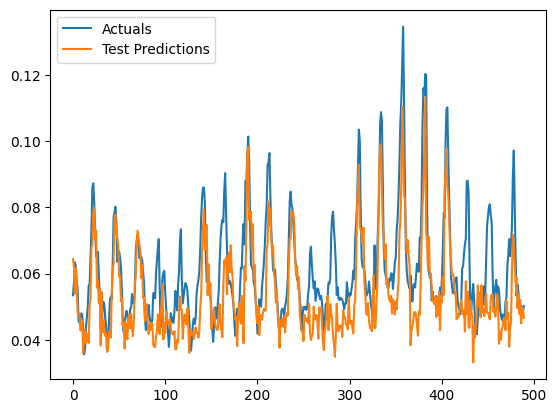

In [39]:
final,mse_value,r2_value,mape_value=plot_predictions1(model4, X2_test, y2_test)
print(mse_value,r2_value,mape_value)
test_predictions = model4.predict(X2_test).flatten()
# test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y2_test},index=df['DateTime'][2003:].index)
# test_results

Text(0, 0.5, 'Active Power in MW')

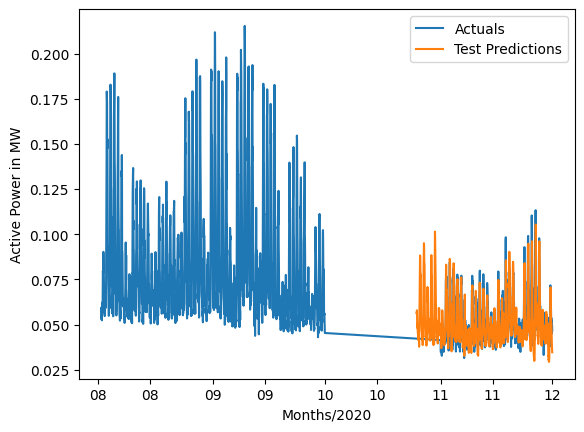

In [40]:
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m'))
fig=plt.plot(target)#[:100])    
fig=plt.plot(test_results['Test Predictions']) 
plt.legend(['Actuals','Test Predictions'])    
plt.xlabel("Months/2020")
plt.ylabel("Active Power in MW")